# Spatial autocorrelation
This notebook measures the spatial autocorrelation of the psuedolableing strategies used in this work. Examples include per-concept, per-cluster and per-random label. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
from utils import deserialize, serialize, deserialize_model

In [3]:
ID = 87#312

In [4]:
proc_path = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/gridsearch_results/k2processors/k9.processor"
proc = deserialize_model(proc_path)

In [5]:
from utils import construct_sprite
G_og = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect/S" + str(ID) + ".obj"
G_og = deserialize(G_og)
S = construct_sprite(G_og, proc, key_in="emb", key_out="concept")

In [ ]:
S.nodes[0].keys()

dict_keys(['voronoi_polygon', 'cell_id', 'center_coord', 'cell_type', 'biomarker_expression', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER', 'emb', 'raw', 'concept'])

key not in prot_feats
min/max values: 0 8
using extended colormap
unique cell types: [0, 1, 2, 3, 4, 5, 6, 7, 8]


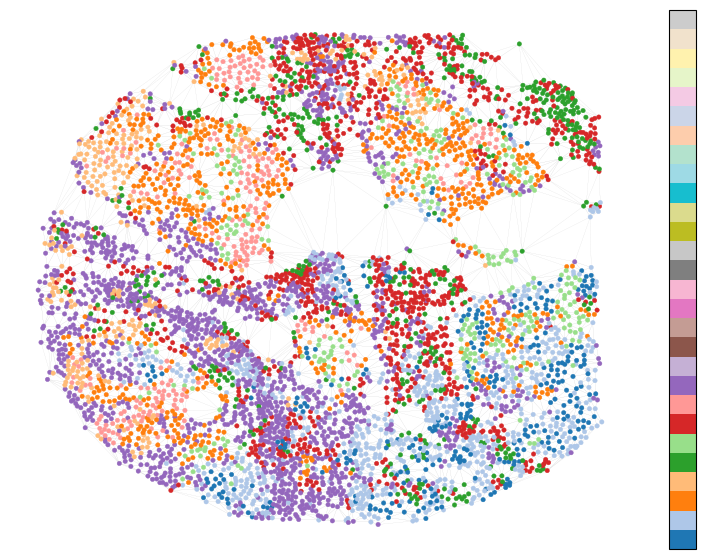

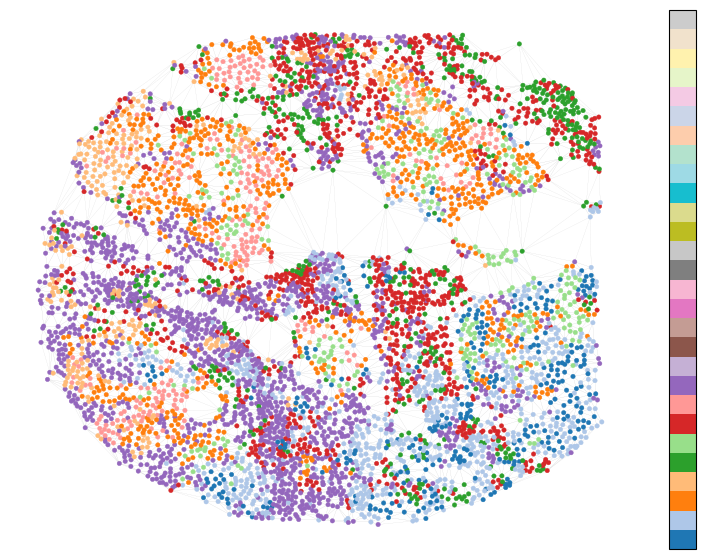

In [7]:
from utils import visualize_cell_graph
visualize_cell_graph(S, key="concept", node_colors=None, edge_flag=True)

### Spatial autocorr using joint counts method
- convert to pysal/geopandas

In [8]:
from utils import convert_graph2df
df = convert_graph2df(S, key="concept")

In [ ]:
df.head()

,x,y,concept
0,22.947266,483.373047,8
1,34.050781,470.789062,8
2,839.055664,1114.792969,4
3,833.133789,1115.903320,4
4,837.575195,1105.169922,6


In [10]:
import pandas as pd
import geopandas
geometry = geopandas.points_from_xy(df['x'], df['y'], df['concept'])
gdf = geopandas.GeoDataFrame(df, geometry=geometry)

In [11]:
import libpysal
from libpysal.weights import Queen, lag_spatial
from libpysal.weights import KNN  # Spatial weights matrix
from esda.join_counts import Join_Counts

w = Queen.from_dataframe(gdf, use_index=False)
# w = KNN.from_dataframe(gdf, k=8)

categorical = gdf['concept'].values

jcs = []
for C in set(categorical):
    y = (categorical == C).astype(int)
    jc = Join_Counts(y, w)
    jcs.append(jc)

In [ ]:
for jc in jcs:
    print(jc.ww)

15938.0
14338.0
14342.0
16045.0
15023.0
16034.0
13021.0
16192.0
11176.0


### Now we try the moran I method using hexbins

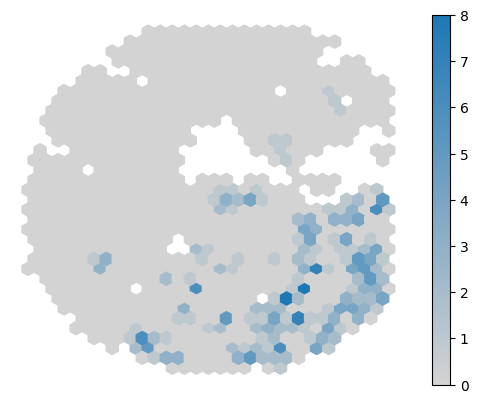

In [13]:
from utils import visualize_concept_density_hexbin
coll = visualize_concept_density_hexbin(S, concept=0, viz_flag=False)

In [14]:
offsets = coll.get_offsets()
arr = coll.get_array()

In [15]:
offsets

array([[  12.21386609,  362.03992417],
       [  12.21386609,  491.01487822],
       [  12.21386609,  555.50235524],
       ...,
       [1094.23296005,  845.69600184],
       [1094.23296005,  910.18347886],
       [1094.23296005,  974.67095588]])

In [ ]:
arr.data

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0.,
       2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 2., 1.,
       0., 0., 0., 0., 0.

In [ ]:
df2 = pd.DataFrame(offsets, columns=["x", "y"])
df2["concept"] = arr.data
df2.head()

,x,y,concept
0,12.213866,362.039924,0.0
1,12.213866,491.014878,0.0
2,12.213866,555.502355,0.0
3,12.213866,619.989832,0.0
4,48.892479,362.039924,0.0


In [18]:
geometry = geopandas.points_from_xy(df2['x'], df2['y'], df2['concept'])
gdf = geopandas.GeoDataFrame(df2, geometry=geometry)

In [19]:
from esda.moran import Moran
w = Queen.from_dataframe(gdf, use_index=False)
mi = Moran(gdf['concept'].values, w)

In [20]:
mi.I

0.3542791227374799

### put it all together to get all stats

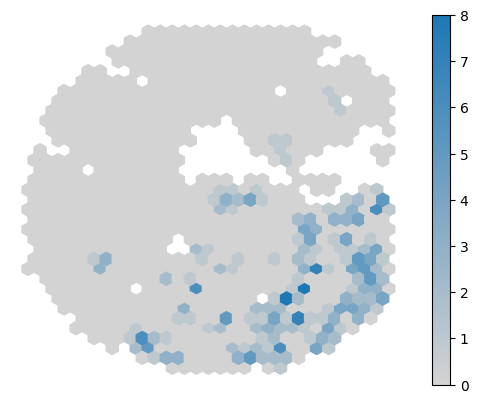

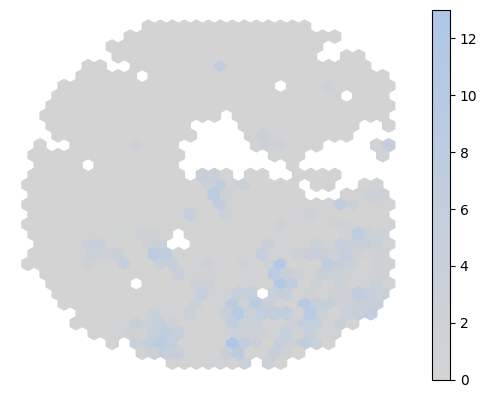

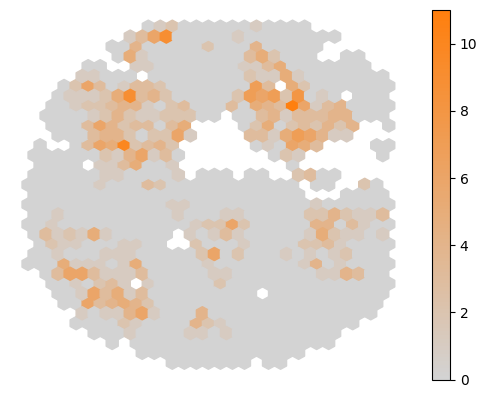

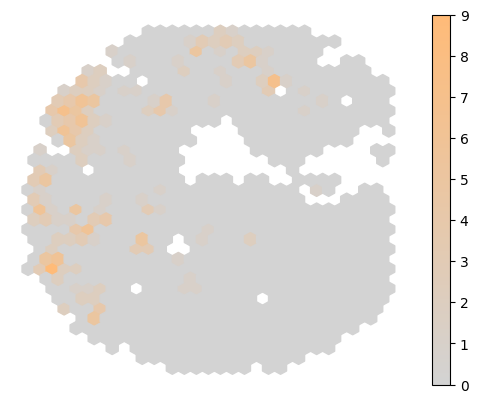

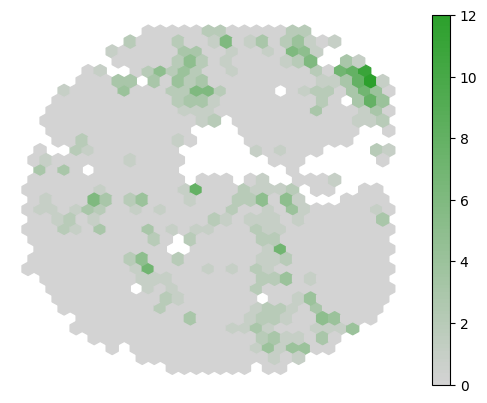

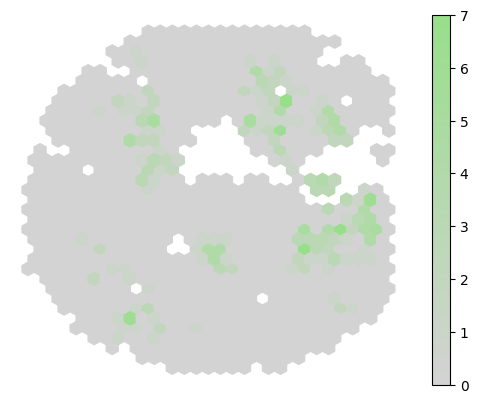

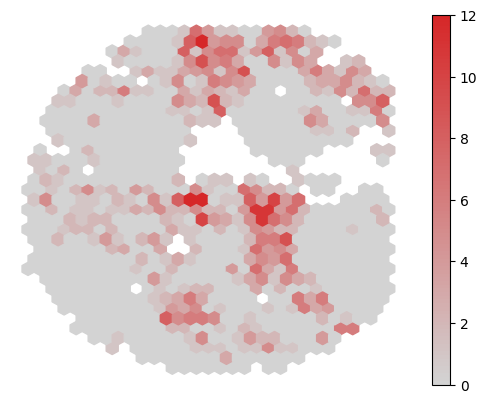

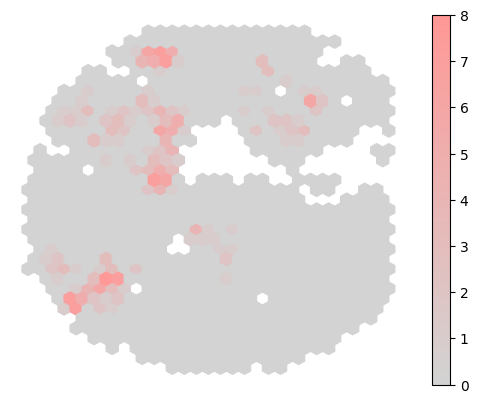

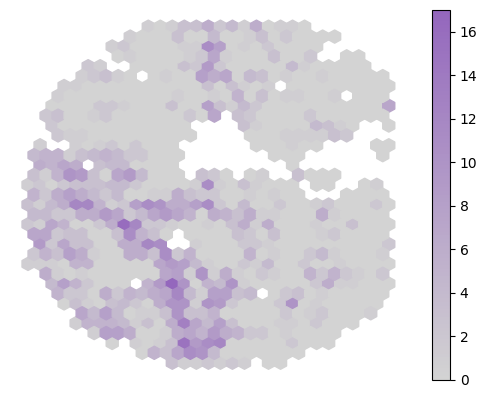

In [21]:
mis = []
for C in set(categorical):
    coll = visualize_concept_density_hexbin(S, concept=C, viz_flag=False)
    offsets = coll.get_offsets()
    arr = coll.get_array()
    df2 = pd.DataFrame(offsets, columns=["x", "y"])
    df2["concept"] = arr.data
    geometry = geopandas.points_from_xy(df2['x'], df2['y'], df2['concept'])
    gdf = geopandas.GeoDataFrame(df2, geometry=geometry)
    w = Queen.from_dataframe(gdf, use_index=False)
    mi = Moran(gdf['concept'].values, w)
    mis.append(mi.I)


In [22]:
mis

[0.3542791227374799,
 0.4714452468712112,
 0.464521064013852,
 0.45030093903778784,
 0.40398016225478245,
 0.378995707579276,
 0.4566691299689536,
 0.4896761996132871,
 0.49249665761626304]

### Now run over all samples
Take a look at `moran.py` and run it from terminal. This avoids the numerous hexbin figures that are generated to compute the moran statistics. This file generates a dictionary object that we can analyze next.

In [23]:
from utils import deserialize
moran_dict = deserialize("/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/moran_dict.obj")
moran_dict[ID]

[0.3542791227374799,
 0.4714452468712112,
 0.464521064013852,
 0.45030093903778784,
 0.40398016225478245,
 0.378995707579276,
 0.4566691299689536,
 0.4896761996132871,
 0.49249665761626304]

In [24]:
# convert to df
df = pd.DataFrame.from_dict(moran_dict, orient='index')
df.head()

,0,1,2,3,4,5,6,7,8
233,0.560266,0.448957,0.359531,0.469832,0.328879,0.349921,0.392090,0.324012,0.545450
188,0.514359,0.368349,0.456405,0.504986,0.427168,0.428757,0.519022,0.435680,0.503483
58,0.380068,0.485595,0.324157,0.591128,0.375858,0.425416,0.517650,0.443942,0.611951
264,0.363619,0.400039,0.497814,0.420754,0.388931,0.533687,0.455877,0.369389,0.465776
41,0.366596,0.479060,0.472423,0.419523,0.432046,0.537723,0.385816,0.400121,0.446157


In [25]:
meds = df.mean()
stds = df.std()

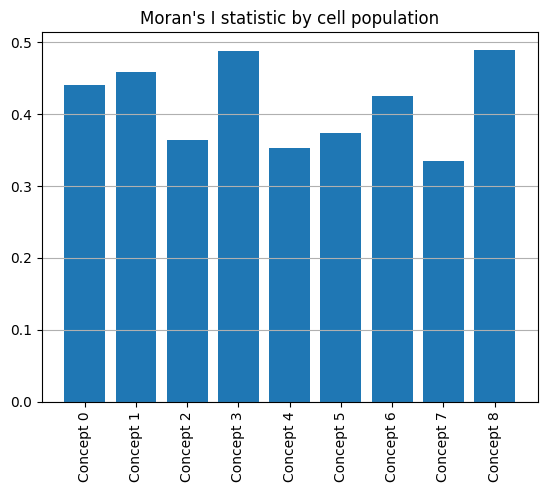

In [26]:
import matplotlib.pyplot as plt
plt.bar(meds.index, meds.values)
plt.xticks(meds.index, ["Concept "+str(s) for s in meds.index], rotation=90)
plt.title("Moran's I statistic by cell population")
plt.grid(axis="y")
plt.show()

### Now we check on K-means clusters on just raw expression

In [27]:
kmeans = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/kmeans_on_raw.obj")

In [28]:
ID = 87 # same example as above
G_og = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect/S" + str(ID) + ".obj"
G_og = deserialize(G_og)
S = construct_sprite(G_og, proc, key_in="emb", key_out="concept")

In [29]:
S.nodes[0].keys()

dict_keys(['voronoi_polygon', 'cell_id', 'center_coord', 'cell_type', 'biomarker_expression', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER', 'emb', 'raw', 'concept'])

In [30]:
kmeans.predict(S.nodes[0]["raw"].reshape(1, -1))

array([3], dtype=int32)

In [31]:
import networkx as nx
X = np.array(list(nx.get_node_attributes(S, "raw").values()))
print(X.shape)
cs = kmeans.predict(X)
cs.shape

(5903, 34)


(5903,)

now check the moran I file again to run code for clusters

In [32]:
moran_dict2 = deserialize("/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/moran_dict_cluster.obj")
moran_dict2[ID]

[0.5460096047811496,
 0.28060928007749847,
 0.47913769414504104,
 0.5653937610332755,
 0.04310351570138046,
 -0.0014949494949494946,
 0.1788003671117179,
 0.4439003828544718,
 0.21746935027418896]

In [33]:
df2 = pd.DataFrame.from_dict(moran_dict2, orient='index')
df2.head()

,0,1,2,3,4,5,6,7,8
233,0.369500,0.185811,0.223905,0.344069,0.106150,NaN,0.135760,0.191427,0.193970
188,0.375604,0.110143,0.123470,0.446725,0.044368,0.017364,0.047707,0.165382,0.057867
58,0.588710,0.285522,0.442561,0.505648,0.054647,-0.001087,0.178868,0.376285,0.127180
264,0.510024,0.197483,0.373084,0.477393,0.040841,-0.002313,0.380243,0.269883,0.045091
41,0.350423,0.244075,0.246135,0.351911,0.006286,0.024070,0.136004,0.257846,0.126513


In [34]:
meds2 = df2.mean()
stds2 = df2.std()

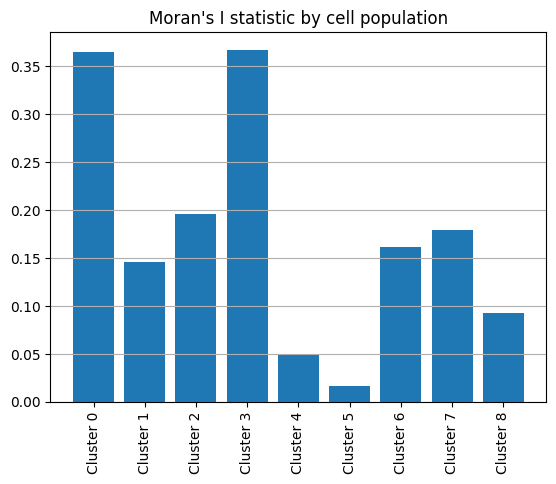

In [35]:
import matplotlib.pyplot as plt
plt.bar(meds2.index, meds2.values)
plt.xticks(meds2.index, ["Cluster "+str(s) for s in meds2.index], rotation=90)
plt.title("Moran's I statistic by cell population")
plt.grid(axis="y")
plt.show()

In [36]:
list(range(2*len(meds.index)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

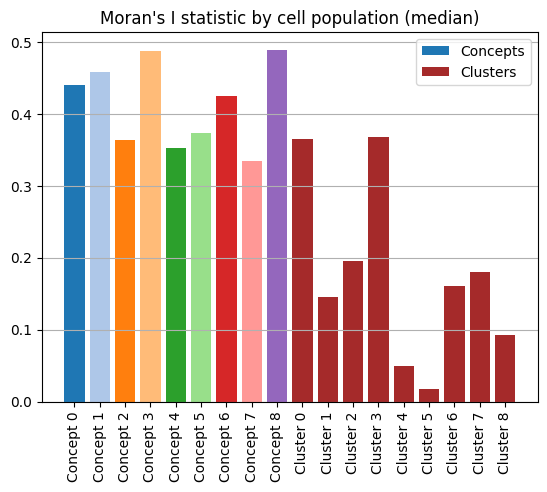

In [37]:
import matplotlib.pyplot as plt

from matplotlib import cm, colors
joint_cmap = colors.ListedColormap(cm.tab20.colors + cm.Pastel2.colors, name='tab40')
joint_cmap.set_bad(color='lightgray') #used to be white
cs = [joint_cmap(i) for i in list(range(len(meds.index)))]

plt.bar(list(range(len(meds.index))), list(meds.values), color=cs)
plt.bar(list(range(len(meds.index), len(meds.index)+len(meds2.index))), list(meds2.values), color="brown")
plt.xticks(list(range(2*len(meds.index))), ["Concept "+str(s) for s in meds.index] + ["Cluster "+str(s) for s in meds2.index], rotation=90)
plt.title("Moran's I statistic by cell population (median)")
plt.legend(["Concepts", "Clusters"])
plt.grid(axis="y")
plt.show()

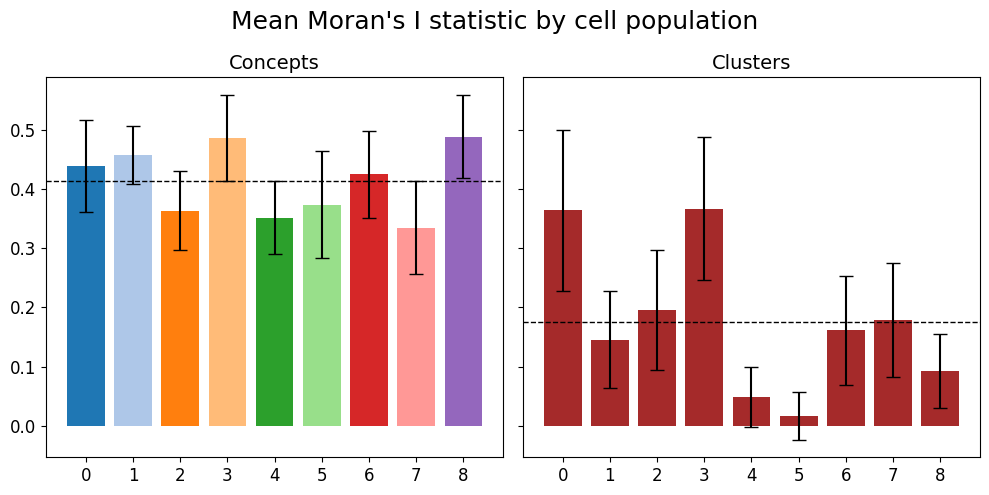

In [42]:
import matplotlib.pyplot as plt

# Example data (replace meds and meds2 with your actual data)
meds_dict = dict(zip(list(range(9)), meds))
meds2_dict = dict(zip(list(range(9)), meds2))
            
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

# First bar plot
ax1.bar(list(range(len(meds))), list(meds_dict.values()), color=cs, yerr=stds, capsize=5)
ax1.set_xticks(list(range(len(meds))))
ax1.set_xticklabels([str(s) for s in meds_dict.keys()], rotation=0, fontsize=12)
ax1.set_title("Concepts", fontsize=14)
ax1.tick_params(axis='y', which='major', labelsize=12)
# add a horizontal line as mean of the meds values
ax1.axhline(meds.mean(), color='k', linestyle='dashed', linewidth=1)

# Second bar plot
ax2.bar(list(range(len(meds2))), list(meds2_dict.values()), color="brown", yerr=stds2, capsize=5)
ax2.set_xticks(list(range(len(meds2))))
ax2.set_xticklabels([str(s) for s in meds2_dict.keys()], rotation=0, fontsize=12)
ax2.set_title("Clusters", fontsize=14)
# add a horizontal line as mean of the meds values
ax2.axhline(meds2.mean(), color='k', linestyle='dashed', linewidth=1)

# Shared y-axis label
fig.suptitle("Mean Moran's I statistic by cell population", fontsize=18)
# ax1.grid(axis="y")
# ax2.grid(axis="y")

plt.tight_layout()
plt.show()